### Combined Scatterplots of deseq2 results

In [ ]:
import pandas as pd
samples = [
    'Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h'
]

in_dir = '/data/reddylab/Alex/collab/20190105_Keith/results/atac_seq/deseq2'
out_dir = '/data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2'
for sample in samples:
    df = pd.read_csv("%s/%s.txt" % (in_dir, sample), sep='\t')
    df_closest= pd.read_csv("%s/counts.rlog.closest_gene.txt" % (in_dir), index_col=0, sep='\t',
                            names=['peak', 'genes', 'distance'])
    df.join(df_closest, how='outer')\
        .to_csv("%s/%s.with_closest_gene.txt" % (out_dir, sample), sep='\t')


In [ ]:
%%writefile /data/reddylab/Revathy/dev/scripts/combined_scatter_plot_of_deseq2_results_v1.py
#!/usr/bin/env python
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['lines.markersize'] = 5
import seaborn as sns
import pandas as pd
import numpy as np
from palettable.cartocolors.qualitative import Bold_8_r
import argparse
from itertools import product

def distance_to_genomic_anno(d, promoter_thres=3000):
    if d < promoter_thres:
        return "Promoter <=3kb"
    return "Distal >3kb"

def get_enrich_group(x, fdr_thres=0.01, labels=["DA", "DEG"], padj_cols=["padj_file1", "padj_file2"]):
    if (x[padj_cols[0]] < fdr_thres) and (x[padj_cols[1]] < fdr_thres):
        return 'sig. %(label_file2)s; sig. %(label_file1)s' % ({"label_file1": labels[0], "label_file2": labels[1]})
#         return 'sig. DEG; sig. DA'
    if (x[padj_cols[0]] < fdr_thres) and (x[padj_cols[1]] >= fdr_thres):
        return 'nonsig. %(label_file2)s; sig. %(label_file1)s' % ({"label_file1": labels[0], "label_file2": labels[1]})
#         return 'nonsig. DEG; sig. DA'
    if (x[padj_cols[0]] >= fdr_thres) and (x[padj_cols[1]] < fdr_thres):
        return 'sig. %(label_file2)s; nonsig. %(label_file1)s' % ({"label_file1": labels[0], "label_file2": labels[1]})
#         return 'sig. DEG; nonsig. DA'
    return 'nonsig. %(label_file2)s; nonsig. %(label_file1)s' % ({"label_file1": labels[0], "label_file2": labels[1]})
    
def order_categories_and_colors(categories, colors, fdr_thres=0.01, labels=["DA", "DEG"]):
    cc = []
    cs = []
    for ix, p in enumerate(product(
        ["nonsig. %s" % labels[1], "sig. %s" % labels[1]],
        ["nonsig. %s" % labels[0], "sig. %s" % labels[0]],
    )):
        lab = "; ".join(p)
        if lab in categories:
            cc.append(lab)
            cs.append(colors[ix])
    return cc, cs
    

def main():
    parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter, \
    description="""

    Given two files containing DESeq2 results, create a combined scatter plot
    to compare the results. By default, the script assumes the input files have
    gene ids in the first column, and will join both files accordingly (outer join).

    """)

    ##################################################
    # required args:

    parser.add_argument("-1", "--input-file1", help="""required, file path to first set of DESeq2 results (x-axis).""", 
                        required=True)
    parser.add_argument("-2", "--input-file2", help="""required, file path to second set of DESeq2 results (y-axis).""", 
                        required=True)
    parser.add_argument("-o","--outname", type=str, help="""required, path and basename used to create output files""", 
                        required=True)

    ##################################################
    # optional args:
    parser.add_argument("--colors", nargs='*', default=['grey'] + Bold_8_r.hex_colors[1:2] + [Bold_8_r.hex_colors[3]],
                       help="""optional, list of colors to use.""")
    parser.add_argument("--suffixes", type=str, nargs=2, default=["_file1", "_file2"], 
                        help="""optional, suffixes used to differentiate common columns (default: ['_file1', '_file2'])""")
    parser.add_argument("--padj-cols", type=str, nargs=2, default=["padj_file1", "padj_file2"], 
                        help="""optional, column names of the padj (significance) values (default: ['padj_file1', 'padj_file2'])""")
    parser.add_argument("--log2fc-cols", type=str, nargs=2, default=["log2FoldChange_file1", "log2FoldChange_file2"], 
                        help="""optional, column names of the log2fc (enrichment) values (default: ['log2FoldChange_file1', 'log2FoldChange_file2'])""")
    parser.add_argument("--legend-group-labels", type=str, nargs=2, default=["DA", "DEG"], 
                        help="""optional, tags used to label elements in legend (default: ['DA', 'DEG'])""")
    parser.add_argument("--axes-labels", type=str, nargs=2, default=["DA", "DEG"], 
                        help="""optional, tags used to label axis (default: ['DA', 'DEG'])""")
    parser.add_argument("--suptitle", type=str, default="Combined scatterplot",
                        help="""optional, figure title (default: %(default)s)""")
    parser.add_argument("--how", type=str, default="outer",
                        help="""optional, how to join both result files. Possible options are: {'left', 'right', 'outer', 'inner'},(default: %(default)s)""")
    parser.add_argument("--genes-to-highlight", type=str, nargs="*",
                        help="""optional, gene_symbol names of genes of interest (will be labeled/highlighted)""")
    parser.add_argument("--gene-name-col", type=str, default="GeneName_file1", 
                        help="""optional, column containing the GeneSymbol names used to filter genes to highlight (default: %(default)s)""")
    parser.add_argument("--output-format", type=str, nargs="*", default=["pdf"],
                        help="""optional, extensions used to create plot (e.g. pdf, png). (default: pdf)""")
    parser.add_argument("--fdr-thres", type=float, default=0.05,
                        help="""optional, threshold used to determine significant hits. (default: %(default)f)""")
    parser.add_argument("--input-file1-join-col", type=str, 
                        help="""optional, column name in input file1 used to merge the results. (default: first column)""")
    parser.add_argument("--input-file2-join-col", type=str, 
                        help="""optional, column name in input file2 used to merge the results. (default: first column)""")
    parser.add_argument("--breakdown-by-genomic-anno-distance-col", type=int,
                        help="""optional, if specified, facetwrap the final scatter plot by genomic annotation using the distance
                        specified in this column. This is only useful when the elements from both sets are not the same, 
                        but they are connected (e.g. peaks and genes)""")
    parser.add_argument("--remove-pseudogenes", action='store_true', default=False,
                        help="""optional, the script will filter out "pseudogene"(s) based on the values in the GeneType column (should be present in only one of the files)""")
    parser.add_argument("--fig_size_x", type=float, default=6, help="fig_size_x", dest="fig_size_x")
    parser.add_argument("--fig_size_y", type=float, default=4, help="fig_size_y", dest="fig_size_y")
    
    ###################################################
    
    args = parser.parse_args()
    fdr_thres = args.fdr_thres
    
    # Load files
    df1 = pd.read_csv(args.input_file1, sep='\t')
    df2 = pd.read_csv(args.input_file2, sep='\t')
    
    if args.input_file1_join_col is not None and args.input_file2_join_col is not None:
        merged = df1.merge(df2, 
                           left_on=args.input_file1_join_col, 
                           right_on=args.input_file2_join_col, 
                           suffixes=args.suffixes,
                           how=args.how)
    else:
        merged = df1.join(df2, how=args.how, lsuffix=args.suffixes[0], rsuffix=args.suffixes[1])

    if args.remove_pseudogenes:
        merged = merged.loc[~merged.GeneType.str.contains('pseudogene'), :]
    
    # If there are NA in the significant columns, replace with 1s
#     merged.loc[merged[args.padj_cols[0]].isna(), args.padj_cols[0]] = 1
#     merged.loc[merged[args.padj_cols[1]].isna(), args.padj_cols[1]] = 1
#     merged[args.padj_cols[0]] = merged[args.padj_cols[0]].astype(float)
#     merged[args.padj_cols[1]] = merged[args.padj_cols[1]].astype(float)
    
    # Break down by combination of significant hits
    merged['group (FDR<%.3f)' % fdr_thres] = merged.apply(get_enrich_group, 
                                                          fdr_thres=fdr_thres,
                                                          labels=args.legend_group_labels,
                                                          padj_cols=args.padj_cols,
                                                          axis = 1)

    merged.to_csv('%s.txt' % (args.outname), sep="\t", index=False)
    
    
    #corr_coef = merged[args.log2fc_cols[0]].corr(merged[args.log2fc_cols[1]])
               
    hue_order, colors_order = order_categories_and_colors((merged['group (FDR<%.3f)' % fdr_thres]).unique(),                           
                                args.colors, 
                                fdr_thres=args.fdr_thres,
                                labels=args.legend_group_labels)

    fig, ax = plt.subplots(figsize=(args.fig_size_x,args.fig_size_y))
    sns.scatterplot(data = merged, x=args.log2fc_cols[0], y=args.log2fc_cols[1], 
                    hue = 'group (FDR<%.3f)' % fdr_thres, hue_order=hue_order,
                    palette= colors_order, s=20, edgecolor=None, alpha=.75)
    
#     xlims = [np.floor(merged[args.log2fc_cols[0]].min()), np.ceil(merged[args.log2fc_cols[0]].max())]
#     ylims = [np.floor(merged[args.log2fc_cols[1]].min()), np.ceil(merged[args.log2fc_cols[1]].max())]
    xlims = [1.1*(merged[args.log2fc_cols[0]].min()), 1.1*(merged[args.log2fc_cols[0]].max())]
    ylims = [1.1*(merged[args.log2fc_cols[1]].min()), 1.1*(merged[args.log2fc_cols[1]].max())]
    plt.xlim(xlims) 
    plt.ylim(ylims)
    plt.vlines(0, ylims[0], ylims[1], linestyle='--', color='grey')
    plt.hlines(0, xlims[0], xlims[1], linestyle='--', color='grey')

    for x, y, t in zip(
        merged[args.log2fc_cols[0]].values, 
        merged[args.log2fc_cols[1]].values, 
        merged[args.gene_name_col]) :
        if t not in args.genes_to_highlight: continue
        ax.annotate('{}'.format(t), xy=(x, y), 
                    xytext=(.75*x, .75*y), #xytext=(5, 0), 
                    ha='left', va='bottom', #ha='left',
                    arrowprops=dict(arrowstyle='-', color='black'))

    plt.legend(bbox_to_anchor=(1.05, 1), frameon=False, fontsize=8)
    plt.ylabel(args.axes_labels[1])#'RNA-seq log2fc')
    plt.xlabel(args.axes_labels[0])#'K27ac ChIP-seq log2fc')
    fig.suptitle('%s for log2FC values; correlation coef = %.3f' % (args.suptitle, corr_coef), fontsize=12)#'Cre+/g5 v Cre+/NTC')

    sns.despine()
    plt.tight_layout()
    for extension in args.output_format:
        plt.savefig('%s.%s' % (args.outname, extension))
    
    return

if __name__ == '__main__':
    main()


In [1]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
module load gcc
for fdr in $(echo 0.01 0.001 0.05);
do 
python /data/reddylab/Revathy/dev/scripts/combined_scatter_plot_of_deseq2_results_v1.py \
    -1 /data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/atac_seq_19/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.with_closest_gene.txt \
    -2 /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt \
    --suffixes "_atacseq" "_rnaseq" \
    --padj-cols "padj_atacseq" "padj_rnaseq" \
    --log2fc-cols "log2FoldChange_atacseq" "log2FoldChange_rnaseq" \
    --legend-group-labels "DA" "DEG" \
    --axes-labels "ATAC-seq log2fc" "RNA-seq log2fc" \
    --how "inner" \
    --genes-to-highlight \
    --gene-name-col "GeneName" \
    --output-format png pdf \
    --fdr-thres ${fdr} \
    --input-file1-join-col "genes" \
    --input-file2-join-col "GeneName" \
    --colors 'grey' '#008695' '#E68310' '#E73F74'  \
    --remove-pseudogenes \
    --fig_size_x 8 \
    --fig_size_y 6 \
    -o /data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_Th0.72hr.rna_atac.combined_scatter_plot.fdr${fdr}  
    
done

Process is terminated.


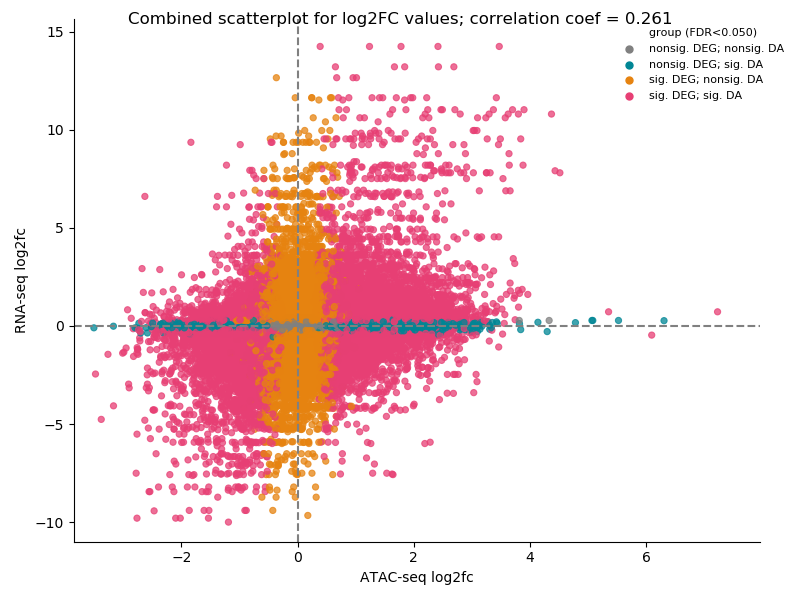

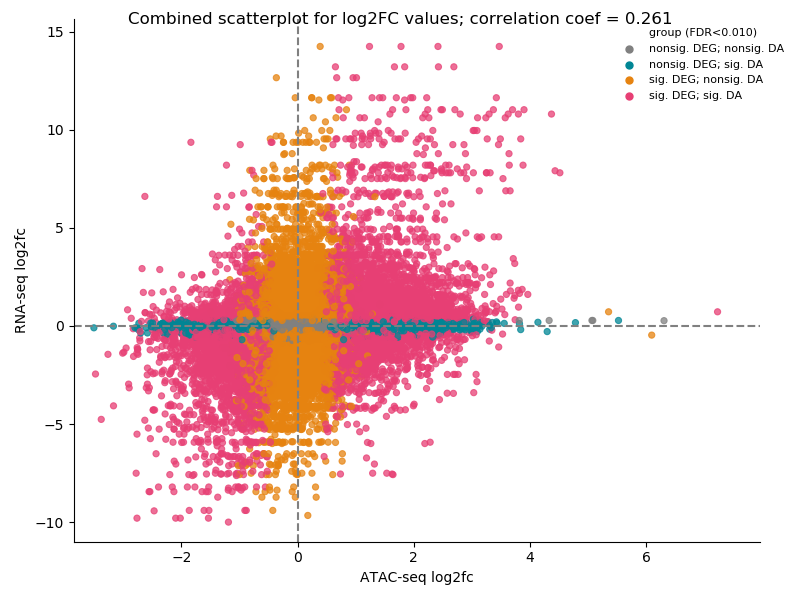

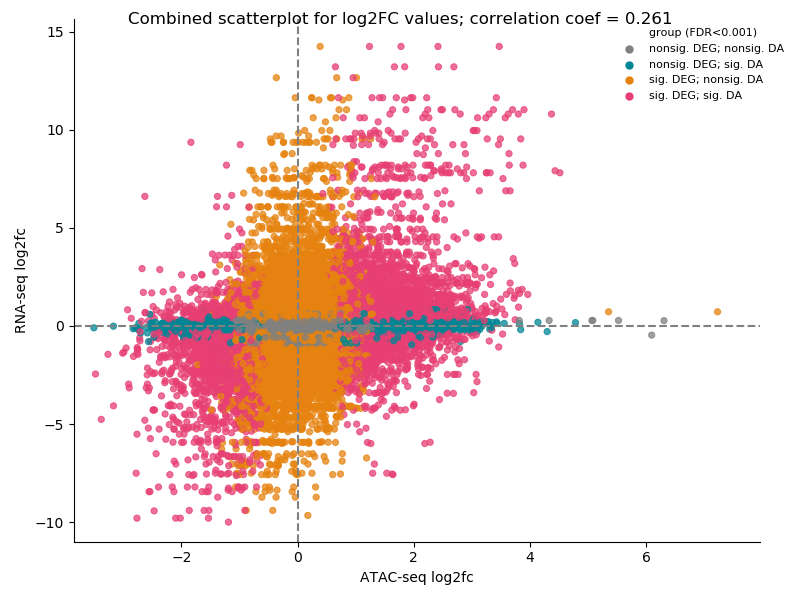

In [1]:
from IPython.display import display,Image
images = ['Th17_Th0.72hr.rna_atac.combined_scatter_plot.fdr0.05',
          'Th17_Th0.72hr.rna_atac.combined_scatter_plot.fdr0.01',
          'Th17_Th0.72hr.rna_atac.combined_scatter_plot.fdr0.001']
for img in images:
    display(Image('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/%s.png' %(img)))
    

In [2]:
import pandas as pd
combined_df = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_Th0.72hr.rna_atac.combined_scatter_plot.fdr0.05.txt', sep='\t')

a_df=combined_df[combined_df['group (FDR<0.050)'] == 'sig. DEG; sig. DA'] ##pink
b_df=combined_df[combined_df['group (FDR<0.050)'] == 'nonsig. DEG; sig. DA'] ##blue
c_df=combined_df[combined_df['group (FDR<0.050)'] == 'sig. DEG; nonsig. DA'] ##yellow
d_df=combined_df[combined_df['group (FDR<0.050)'] == 'nonsig. DEG; nonsig. DA'] ##gray
# print(combined_df.shape)
# print(c_df.shape)

#c_df.head(5)
a_cor=a_df['log2FoldChange_atacseq'].corr(a_df['log2FoldChange_rnaseq'])
b_cor=b_df['log2FoldChange_atacseq'].corr(b_df['log2FoldChange_rnaseq'])
c_cor=c_df['log2FoldChange_atacseq'].corr(c_df['log2FoldChange_rnaseq'])
d_cor=d_df['log2FoldChange_atacseq'].corr(d_df['log2FoldChange_rnaseq'])

print(a_cor)
print(b_cor)
print(c_cor)
print(d_cor)

0.3697542656659402
0.09559745252552586
0.11003705679276977
0.040024998629335125


In [3]:
import pandas as pd
combined_df = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_Th0.72hr.rna_atac.combined_scatter_plot.fdr0.01.txt', sep='\t')

a_df=combined_df[combined_df['group (FDR<0.010)'] == 'sig. DEG; sig. DA'] ##pink
b_df=combined_df[combined_df['group (FDR<0.010)'] == 'nonsig. DEG; sig. DA'] ##blue
c_df=combined_df[combined_df['group (FDR<0.010)'] == 'sig. DEG; nonsig. DA'] ##yellow
d_df=combined_df[combined_df['group (FDR<0.010)'] == 'nonsig. DEG; nonsig. DA'] ##gray
# print(combined_df.shape)
# print(c_df.shape)

#c_df.head(5)
a_cor=a_df['log2FoldChange_atacseq'].corr(a_df['log2FoldChange_rnaseq'])
b_cor=b_df['log2FoldChange_atacseq'].corr(b_df['log2FoldChange_rnaseq'])
c_cor=c_df['log2FoldChange_atacseq'].corr(c_df['log2FoldChange_rnaseq'])
d_cor=d_df['log2FoldChange_atacseq'].corr(d_df['log2FoldChange_rnaseq'])

print(a_cor)
print(b_cor)
print(c_cor)
print(d_cor)

0.4067369173473456
0.0935267785699633
0.1324725599297473
0.05330273640856112


In [4]:
import pandas as pd
combined_df = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_Th0.72hr.rna_atac.combined_scatter_plot.fdr0.001.txt', sep='\t')

a_df=combined_df[combined_df['group (FDR<0.001)'] == 'sig. DEG; sig. DA'] ##pink
b_df=combined_df[combined_df['group (FDR<0.001)'] == 'nonsig. DEG; sig. DA'] ##blue
c_df=combined_df[combined_df['group (FDR<0.001)'] == 'sig. DEG; nonsig. DA'] ##yellow
d_df=combined_df[combined_df['group (FDR<0.001)'] == 'nonsig. DEG; nonsig. DA'] ##gray
# print(combined_df.shape)
# print(c_df.shape)

#c_df.head(5)
a_cor=a_df['log2FoldChange_atacseq'].corr(a_df['log2FoldChange_rnaseq'])
b_cor=b_df['log2FoldChange_atacseq'].corr(b_df['log2FoldChange_rnaseq'])
c_cor=c_df['log2FoldChange_atacseq'].corr(c_df['log2FoldChange_rnaseq'])
d_cor=d_df['log2FoldChange_atacseq'].corr(d_df['log2FoldChange_rnaseq'])

print(a_cor)
print(b_cor)
print(c_cor)
print(d_cor)

0.4435543495106152
0.16183869318949798
0.1701926190293801
0.07987613197312723


### Co-ordinate plot with new ATACseq data (2020 ATACSTAR data)

In [2]:
%%bash
wc -l /data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.rlog.with_closest_gene.txt
wc -l /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt
wc -l /data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/atac_seq_19/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.with_closest_gene.txt


68376 /data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.rlog.with_closest_gene.txt
11449 /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt
103308 /data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/atac_seq_19/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.with_closest_gene.txt


In [1]:
import pandas as pd
samples = [
    'Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert'
]
data_dir = '/data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2'
for sample in samples:
    df = pd.read_csv("%s/%s.txt" % (data_dir, sample), sep='\t')
    df_closest= pd.read_csv("%s/%s.rlog.closest_gene.txt" % (data_dir, sample), index_col=0, sep='\t',
                            names=['peak', 'genes', 'distance'])
    df.join(df_closest, how='outer')\
        .to_csv("%s/%s.with_closest_gene.txt" % (data_dir, sample), sep='\t')


Co-ordinate plots

In [2]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
module load gcc
for fdr in $(echo 0.01 0.001 0.05);
do 
python /data/reddylab/Revathy/scripts/combined_scatter_plot_of_deseq2_results_v1.py \
    -1 /data/reddylab/Revathy/collabs/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt \
    -2 /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt \
    --suffixes "_atacseq" "_rnaseq" \
    --padj-cols "padj_atacseq" "padj_rnaseq" \
    --log2fc-cols "log2FoldChange_atacseq" "log2FoldChange_rnaseq" \
    --legend-group-labels "DA" "DEG" \
    --axes-labels "ATAC-seq log2fc" "RNA-seq log2fc" \
    --how "inner" \
    --genes-to-highlight "Rorc" "Maf" "Il17a"\
    --gene-name-col "GeneName" \
    --output-format png pdf \
    --fdr-thres ${fdr} \
    --input-file1-join-col "genes" \
    --input-file2-join-col "GeneName" \
    --colors 'grey' '#008695' '#E68310' '#E73F74'  \
    --remove-pseudogenes \
    --fig_size_x 8 \
    --fig_size_y 6 \
    -o /data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr${fdr}  
    
done

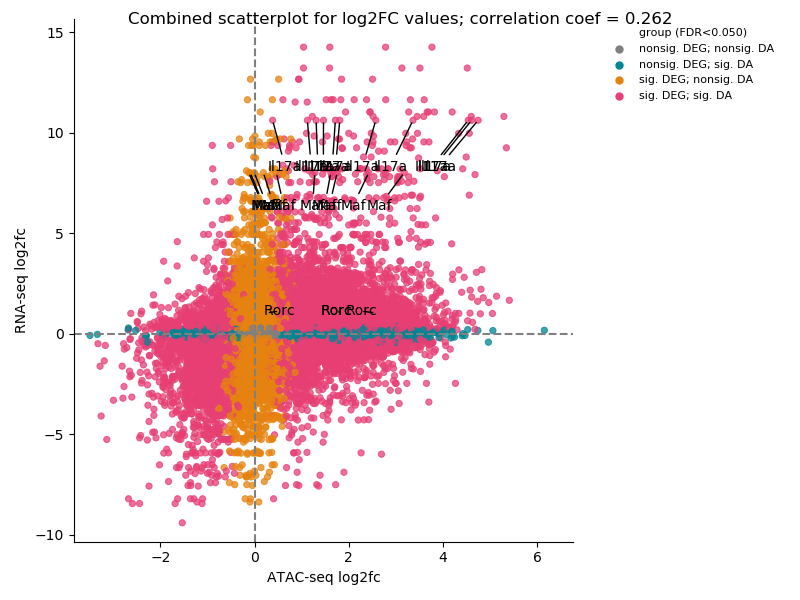

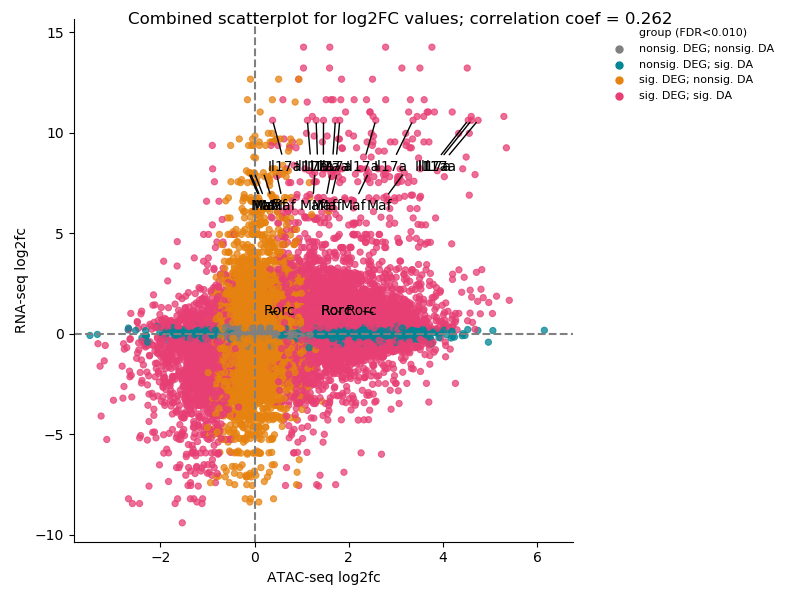

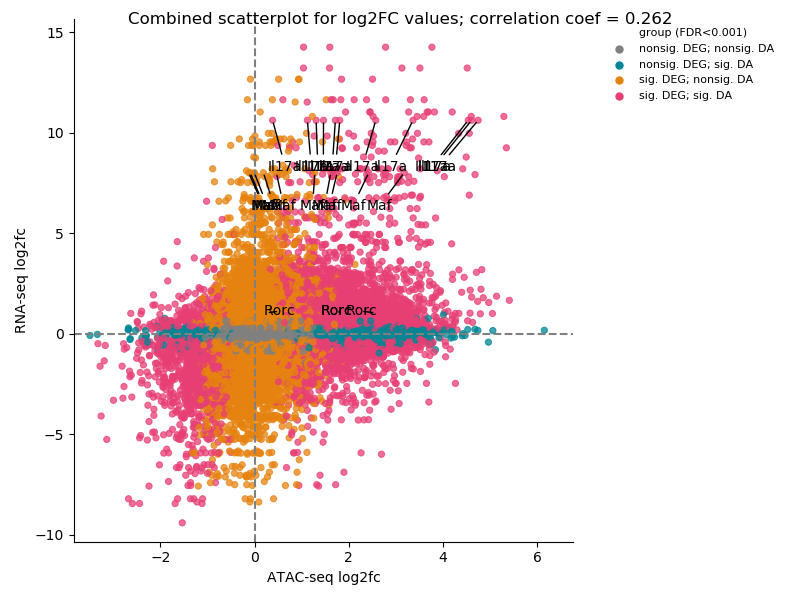

In [3]:
from IPython.display import display,Image
images = ['Th17_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr0.05',
          'Th17_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr0.01',
          'Th17_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr0.001']
for img in images:
    display(Image('/data/reddylab/Revathy/collabs/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/%s.png' %(img)))
    

Co-ordinate plots with the promoters and non-promoters seperated

In [1]:
import pandas as pd 
peak_20 = pd.read_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/deseq2/Th17.72hrs.ASTARR.insert_vs_Th0.72hrs.ASTARR.insert.with_closest_gene.txt', sep='\t')
peak_19 = pd.read_csv('/data/reddylab/Revathy/dev/atac-seq_Siklenka/results/atac_seq_19/Th17.atacseq.activated_sorted.072h_vs_Th0.atacseq.activated_sorted.072h.with_closest_gene.txt', sep='\t')
genes = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/differential_testing/deseq2/timeseries/Th17.Sorted.72hr_vs_mmTh0.Sorted.72hr.with_genes.txt', sep='\t')


In [3]:
##filter out those peaks from the new set of ATCseq peaks where the peak region notation starts with 'chr'

peak_20_filtered = peak_20[peak_20['Unnamed: 0'].str.startswith('chr')]
peak_20_filtered.shape

(63727, 8)

In [22]:
special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']

peak_20_spl = peak_20_filtered[(peak_20_filtered['genes'].isin(special_genes)) & (peak_20_filtered['padj']<0.05)]
peak_20_spl

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,genes,distance
3530,chr11_100886090_100886462,95.154636,1.063806,0.215032,1.107952e-07,4.649462e-07,Stat3,0
3531,chr11_100891415_100892652,314.771909,0.375844,0.115630,7.629818e-04,1.755557e-03,Stat3,0
3533,chr11_100897686_100898303,80.004186,-1.011329,0.212781,3.416963e-07,1.345548e-06,Stat3,0
3534,chr11_100899572_100899958,75.415539,0.957652,0.248082,2.186089e-05,6.639457e-05,Stat3,0
3535,chr11_100904751_100905370,138.022886,1.297113,0.200021,7.077066e-12,4.657152e-11,Stat3,0
3536,chr11_100912426_100913302,380.094681,-0.619167,0.107128,3.416793e-09,1.704415e-08,Stat3,0
3537,chr11_100921064_100921970,929.457147,0.175534,0.075715,1.834775e-02,3.099964e-02,Stat3,0
3539,chr11_100933642_100934452,163.820917,-0.904752,0.149650,3.523609e-10,1.953389e-09,Stat3,0
3540,chr11_100938823_100940227,2386.960024,0.499867,0.052767,1.505957e-21,2.138445e-20,Stat3,0
8054,chr11_97109640_97110039,69.102965,0.833479,0.252247,2.492050e-04,6.306602e-04,Tbx21,0


In [11]:
#filter the sig DA peaks

peak_20_sig = peak_20_filtered[peak_20_filtered['padj'] < 0.05]
peak_19_sig = peak_19[peak_19['padj'] < 0.05]
print(peak_20_sig.shape)
print(peak_19_sig.shape)

(40117, 8)
(46484, 9)


In [12]:
## filter the promoter regions from the peaks in the 2020 and 2019 ATACseq data

peak_20_promoter = peak_20[(peak_20['distance'] < 1000) & (peak_20['Unnamed: 0'].str.startswith('chr'))]
peak_19_promoter = peak_19[(peak_19['distance'] < 1000) & (peak_19['Unnamed: 0'].str.startswith('chr'))]

There are 87567 promoter region (<1kb) in the 2019 ATACseq data and 54851 promoter regions in the 2020 ATACseq data. The total number of peaks in the 2019 ATACseq data is 103307 and that in the 2020 ATACseq data is 63786.
There are 40117 sig. DA peaks in 2020 data and 46484 sig. DA peaks in 2019 data 

In [2]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1" # u'\u03C1'
    ax.annotate('%s = %.2f' % (rho, r), xy=(.1, .9), xycoords=ax.transAxes)

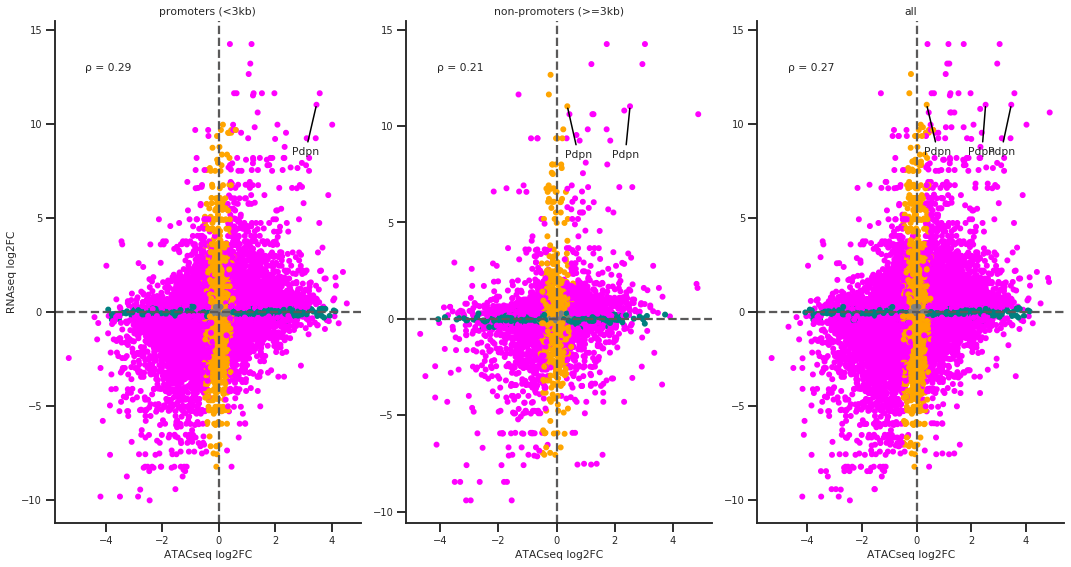

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
import numpy as np
%matplotlib inline


merged = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr0.05.txt', sep='\t')
merged['Annotation'] = ['Promoter' if (x < 3000) else 'Non-promoter' for x in merged['distance']] 
# merged_promoter = merged[merged['Annotation'] == 'Promoter']
# merged_nonpromoter = merged[merged['Annotation'] == 'Non-promoter']
colors = {'sig. DEG; sig. DA': 'magenta', 'sig. DEG; nonsig. DA': 'orange', 'nonsig. DEG; sig. DA': 'teal', 'nonsig. DEG; nonsig. DA': 'grey'}


sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("talk", font_scale=0.9)
fig, ax = plt.subplots(1, 3, figsize=(16,8))

ax1 = ax.flatten()[0]
points = ax1.scatter(
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_atacseq'],
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_rnaseq'],
    c=merged.loc[np.abs(merged.distance)<3000, 'group (FDR<0.050)'].apply(lambda x: colors[x]),
    vmax=1e4, s=20)
corrfunc(
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_atacseq'],
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_rnaseq'],
    ax=ax1, method='spearman'
)

ax2 = ax.flatten()[1]
points = ax2.scatter(
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_atacseq'],
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_rnaseq'],
    c=merged.loc[np.abs(merged.distance)>=3000, 'group (FDR<0.050)'].apply(lambda x: colors[x]),
    vmax=1e4, s=20)
corrfunc(
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_atacseq'],
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_rnaseq'],
    ax=ax2, method='spearman'
)

ax3 = ax.flatten()[2]
points = ax3.scatter(
    merged.loc[:, 'log2FoldChange_atacseq'],
    merged.loc[:, 'log2FoldChange_rnaseq'],
    c=merged.loc[:, 'group (FDR<0.050)'].apply(lambda x: colors[x]),
    vmax=1e4, s=20)
corrfunc(
    merged.loc[:, 'log2FoldChange_atacseq'],
    merged.loc[:, 'log2FoldChange_rnaseq'],
    ax=ax3, method='spearman'
)

ax1.set_xlim(ax1.get_xlim())
ax1.set_ylim(ax1.get_ylim())
ax1.vlines(0, ax1.get_ylim()[0], ax1.get_ylim()[1], color='#5A5959', linestyle='--')
ax1.hlines(0, ax1.get_xlim()[0], ax1.get_xlim()[1], color='#5A5959', linestyle='--')
ax1.set_xlabel('ATACseq log2FC')
ax1.set_ylabel('RNAseq log2FC')
ax1.set_title('promoters (<3kb)')

ax2.set_xlim(ax2.get_xlim())
ax2.set_ylim(ax2.get_ylim())
ax2.vlines(0, ax2.get_ylim()[0], ax2.get_ylim()[1], color='#5A5959', linestyle='--')
ax2.hlines(0, ax2.get_xlim()[0], ax2.get_xlim()[1], color='#5A5959', linestyle='--')
ax2.set_xlabel('ATACseq log2FC')
ax2.set_title('non-promoters (>=3kb)')

ax3.set_xlim(ax3.get_xlim())
ax3.set_ylim(ax3.get_ylim())
ax3.set_xlabel('ATACseq log2FC')
ax3.set_title('all')
ax3.vlines(0, ax3.get_ylim()[0], ax3.get_ylim()[1], color='#5A5959', linestyle='--')
ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], color='#5A5959', linestyle='--')

sig_genes = ['Pdpn']

### can take unique of the genes with the highest values of log2FC for annotating
for x, y, t in zip(
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_atacseq'], 
    merged.loc[np.abs(merged.distance)<3000, 'log2FoldChange_rnaseq'], 
    merged.loc[np.abs(merged.distance)<3000, 'genes']):
    if t not in sig_genes: continue
    ax1.annotate('{}'.format(t), xy=(x, y), 
                    xytext=(.75*x, .75*y), #xytext=(5, 0), 
                    ha='left', va='bottom', #ha='left',
                    arrowprops=dict(arrowstyle='-', color='black'))
    
for x, y, t in zip(
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_atacseq'], 
    merged.loc[np.abs(merged.distance)>=3000, 'log2FoldChange_rnaseq'], 
    merged.loc[np.abs(merged.distance)>=3000, 'genes']):
    if t not in sig_genes: continue
    ax2.annotate('{}'.format(t), xy=(x, y), 
                    xytext=(.75*x, .75*y), #xytext=(5, 0), 
                    ha='left', va='bottom', #ha='left',
                    arrowprops=dict(arrowstyle='-', color='black'))

for x, y, t in zip(
    merged.loc[:, 'log2FoldChange_atacseq'], 
    merged.loc[:, 'log2FoldChange_rnaseq'], 
    merged.loc[:, 'genes']):
    if t not in sig_genes: continue
    ax3.annotate('{}'.format(t), xy=(x, y), 
                    xytext=(.75*x, .75*y), #xytext=(5, 0), 
                    ha='left', va='bottom', #ha='left',
                    arrowprops=dict(arrowstyle='-', color='black'))

# plt.legend(bbox_to_anchor=(1,1), frameon=False, fontsize=10, labels=labels)
# plt.ylabel('RNAseq logFC')
# plt.xlabel('ATACseq logFC')

sns.despine()
plt.tight_layout()
#plt.savefig('/data/reddylab/Revathy/dev/Keith/data/integrative/plots/coordinate_plot_ATAC_RNA_Pdpn.pdf')

plt.show()

In [ ]:
merged.loc[:, 'group (FDR<0.050)'].apply(lambda x: labels[x])

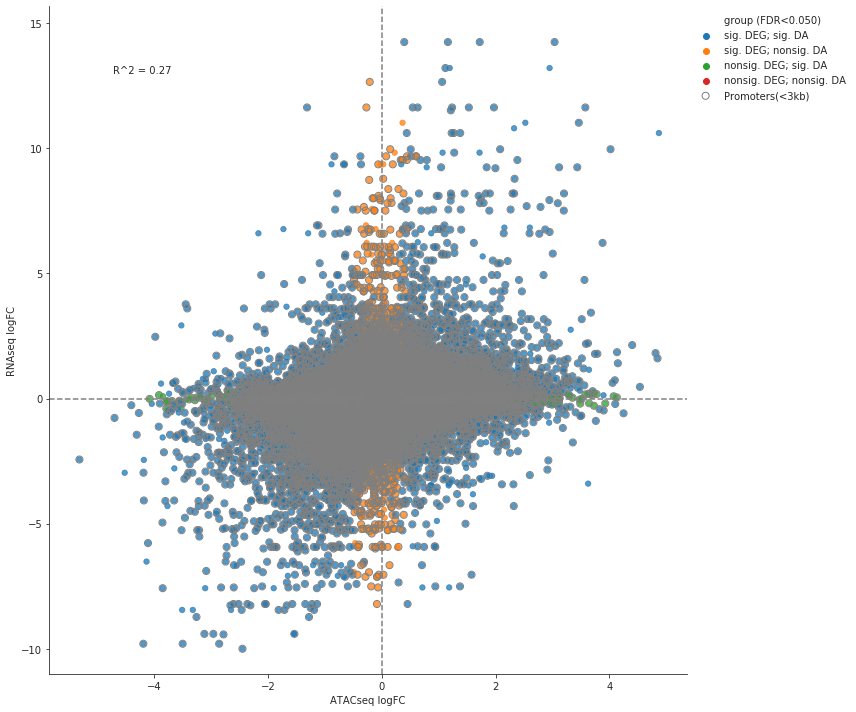

In [13]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig, ax = plt.subplots(1, 1, figsize=(12,10))

sns.scatterplot(data=merged, x=merged.log2FoldChange_atacseq, y=merged.log2FoldChange_rnaseq, 
                hue= 'group (FDR<0.050)', s=30, edgecolor=None, alpha=.75)

plt.scatter(merged.loc[merged.distance<3000, 'log2FoldChange_atacseq'],
    merged.loc[merged.distance<3000, 'log2FoldChange_rnaseq'],
    facecolors='none', edgecolor='grey', vmax=1e4, s=50, label='Promoters(<3kb)')

# corrfunc(
#     merged.loc[merged.distance<3000, 'log2FoldChange_atacseq'],
#     merged.loc[merged.distance<3000, 'log2FoldChange_rnaseq'],
#     ax=ax, method='spearman')

corrfunc(
    merged.loc[:, 'log2FoldChange_atacseq'],
    merged.loc[:, 'log2FoldChange_rnaseq'],
    ax=ax, method='spearman')

xlims = [1.1*(merged['log2FoldChange_atacseq'].min()), 1.1*(merged['log2FoldChange_atacseq'].max())]
ylims = [1.1*(merged['log2FoldChange_rnaseq'].min()), 1.1*(merged['log2FoldChange_rnaseq'].max())]
plt.xlim(xlims) 
plt.ylim(ylims)
plt.vlines(0, ylims[0], ylims[1], linestyle='--', color='grey')
plt.hlines(0, xlims[0], xlims[1], linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1, 1), frameon=False, fontsize=10)
plt.ylabel('RNAseq logFC')
plt.xlabel('ATACseq logFC')

sns.despine()
plt.tight_layout()



In [24]:
merged[(merged['distance'] >= 0) & merged['distance'] <=3000]

,Unnamed: 0_atacseq,baseMean_atacseq,log2FoldChange_atacseq,lfcSE_atacseq,pvalue_atacseq,padj_atacseq,genes,distance,Unnamed: 0_rnaseq,baseMean_rnaseq,log2FoldChange_rnaseq,lfcSE_rnaseq,pvalue_rnaseq,padj_rnaseq,GeneName,GeneType,group (FDR<0.050),Annotation
0,chr10_100542847_100543789,647.960047,0.736237,0.090788,1.904858e-16,1.856429e-15,Cep290,0,ENSMUSG00000019971.10,857.524843,0.710229,0.087714,1.619129e-16,7.198366e-16,Cep290,protein_coding,sig. DEG; sig. DA,Promoter
1,chr10_100566978_100567875,103.607805,0.500735,0.202476,7.151886e-03,1.337840e-02,Cep290,0,ENSMUSG00000019971.10,857.524843,0.710229,0.087714,1.619129e-16,7.198366e-16,Cep290,protein_coding,sig. DEG; sig. DA,Promoter
2,chr10_100588513_100589541,270.918472,-0.047468,0.138337,7.191417e-01,7.636286e-01,4930430F08Rik,0,ENSMUSG00000046567.10,610.372197,0.737065,0.131528,5.157430e-09,1.385152e-08,4930430F08Rik,protein_coding,sig. DEG; nonsig. DA,Promoter
3,chr10_105280932_105281265,40.985387,-0.096731,0.259936,6.714017e-01,7.211109e-01,Tmtc2,0,ENSMUSG00000036019.8,421.805731,1.366337,0.155483,1.363908e-20,7.488736e-20,Tmtc2,protein_coding,sig. DEG; nonsig. DA,Promoter
4,chr10_105408749_105408999,102.376893,1.618725,0.233237,2.062175e-13,1.559245e-12,Tmtc2,0,ENSMUSG00000036019.8,421.805731,1.366337,0.155483,1.363908e-20,7.488736e-20,Tmtc2,protein_coding,sig. DEG; sig. DA,Promoter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33669,chrY_1010045_1010716,63.025444,-0.101921,0.269386,6.638209e-01,7.143260e-01,Eif2s3y,0,ENSMUSG00000069049.11,1430.994354,0.269068,0.344145,3.067156e-01,3.523259e-01,Eif2s3y,protein_coding,nonsig. DEG; nonsig. DA,Promoter
33670,chrY_1115299_1116065,74.541436,0.064938,0.381923,8.280488e-01,8.583953e-01,Uty,0,ENSMUSG00000068457.14,564.070516,0.279146,0.346791,2.907877e-01,3.355107e-01,Uty,protein_coding,nonsig. DEG; nonsig. DA,Promoter
33671,chrY_1245087_1246027,114.778679,-0.018767,0.387786,9.503822e-01,9.598625e-01,Uty,0,ENSMUSG00000068457.14,564.070516,0.279146,0.346791,2.907877e-01,3.355107e-01,Uty,protein_coding,nonsig. DEG; nonsig. DA,Promoter
33672,chrY_1269395_1269666,76.585068,0.503898,0.446383,1.291841e-01,1.737656e-01,Ddx3y,0,ENSMUSG00000069045.11,1429.488314,0.720989,0.122169,9.582348e-10,2.726111e-09,Ddx3y,protein_coding,sig. DEG; nonsig. DA,Promoter


In [28]:
merged[merged['distance'] <= 3000]

,Unnamed: 0_atacseq,baseMean_atacseq,log2FoldChange_atacseq,lfcSE_atacseq,pvalue_atacseq,padj_atacseq,genes,distance,Unnamed: 0_rnaseq,baseMean_rnaseq,log2FoldChange_rnaseq,lfcSE_rnaseq,pvalue_rnaseq,padj_rnaseq,GeneName,GeneType,group (FDR<0.050),Annotation
0,chr10_100542847_100543789,647.960047,0.736237,0.090788,1.904858e-16,1.856429e-15,Cep290,0,ENSMUSG00000019971.10,857.524843,0.710229,0.087714,1.619129e-16,7.198366e-16,Cep290,protein_coding,sig. DEG; sig. DA,Promoter
1,chr10_100566978_100567875,103.607805,0.500735,0.202476,7.151886e-03,1.337840e-02,Cep290,0,ENSMUSG00000019971.10,857.524843,0.710229,0.087714,1.619129e-16,7.198366e-16,Cep290,protein_coding,sig. DEG; sig. DA,Promoter
2,chr10_100588513_100589541,270.918472,-0.047468,0.138337,7.191417e-01,7.636286e-01,4930430F08Rik,0,ENSMUSG00000046567.10,610.372197,0.737065,0.131528,5.157430e-09,1.385152e-08,4930430F08Rik,protein_coding,sig. DEG; nonsig. DA,Promoter
3,chr10_105280932_105281265,40.985387,-0.096731,0.259936,6.714017e-01,7.211109e-01,Tmtc2,0,ENSMUSG00000036019.8,421.805731,1.366337,0.155483,1.363908e-20,7.488736e-20,Tmtc2,protein_coding,sig. DEG; nonsig. DA,Promoter
4,chr10_105408749_105408999,102.376893,1.618725,0.233237,2.062175e-13,1.559245e-12,Tmtc2,0,ENSMUSG00000036019.8,421.805731,1.366337,0.155483,1.363908e-20,7.488736e-20,Tmtc2,protein_coding,sig. DEG; sig. DA,Promoter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33669,chrY_1010045_1010716,63.025444,-0.101921,0.269386,6.638209e-01,7.143260e-01,Eif2s3y,0,ENSMUSG00000069049.11,1430.994354,0.269068,0.344145,3.067156e-01,3.523259e-01,Eif2s3y,protein_coding,nonsig. DEG; nonsig. DA,Promoter
33670,chrY_1115299_1116065,74.541436,0.064938,0.381923,8.280488e-01,8.583953e-01,Uty,0,ENSMUSG00000068457.14,564.070516,0.279146,0.346791,2.907877e-01,3.355107e-01,Uty,protein_coding,nonsig. DEG; nonsig. DA,Promoter
33671,chrY_1245087_1246027,114.778679,-0.018767,0.387786,9.503822e-01,9.598625e-01,Uty,0,ENSMUSG00000068457.14,564.070516,0.279146,0.346791,2.907877e-01,3.355107e-01,Uty,protein_coding,nonsig. DEG; nonsig. DA,Promoter
33672,chrY_1269395_1269666,76.585068,0.503898,0.446383,1.291841e-01,1.737656e-01,Ddx3y,0,ENSMUSG00000069045.11,1429.488314,0.720989,0.122169,9.582348e-10,2.726111e-09,Ddx3y,protein_coding,sig. DEG; nonsig. DA,Promoter


In [16]:
merged.shape

(33674, 18)

In [38]:
import pandas as pd

merged = pd.read_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/results/rna_seq/integration/rna_atac/Th17_Th0.72hr.rna_atac.new.combined_scatter_plot.fdr0.05.txt', sep='\t')
#merged.sort_values(by=['log2FoldChange_atacseq','log2FoldChange_rnaseq'], ascending=False).head(10)
merged_test = merged[(merged['log2FoldChange_rnaseq']>10) & (merged['log2FoldChange_atacseq']>0) & (merged['distance']<3000)]
merged_test['genes'].unique()

array(['Tgfbi', 'Cyp1b1', 'Il24', 'Il17a', 'Il21', 'Pdpn', 'Il23r'],
      dtype=object)

In [29]:
sig_genes = ['Batf','Stat3','Irf4','Il17a','Rorc','Maf']

merged_subset = merged[['log2FoldChange_atacseq','log2FoldChange_rnaseq','genes','group (FDR<0.050)']][merged.genes.isin(sig_genes)]
merged_subset

,log2FoldChange_atacseq,log2FoldChange_rnaseq,genes,group (FDR<0.050)
1778,1.063806,0.649945,Stat3,sig. DEG; sig. DA
1779,0.375844,0.649945,Stat3,sig. DEG; sig. DA
1780,0.000632,0.649945,Stat3,sig. DEG; nonsig. DA
1781,-1.011329,0.649945,Stat3,sig. DEG; sig. DA
1782,0.957652,0.649945,Stat3,sig. DEG; sig. DA
1783,1.297113,0.649945,Stat3,sig. DEG; sig. DA
1784,-0.619167,0.649945,Stat3,sig. DEG; sig. DA
1785,0.175534,0.649945,Stat3,sig. DEG; sig. DA
1786,0.062943,0.649945,Stat3,sig. DEG; nonsig. DA
1787,-0.904752,0.649945,Stat3,sig. DEG; sig. DA


In [ ]:
#[(merged.genes=='Bcl11b') | (merged.genes=='Etv6') | (merged.genes=='Jmjd3') | (merged.genes=='Fosl2')]

In [64]:
merged['Annotation'] = ['Promoter' if (x < 3000) else 'Non-promoter' for x in merged['distance']] 
merged.Annotation.value_counts()

Promoter        31092
Non-promoter     2582
Name: Annotation, dtype: int64

- 'Promoter' if (x < 3000 | x >= -3000) else 'Non-promoter': **Promoter=31378, Non-promoter=2296**
- 'Promoter' if (x < 3000 & x >= -3000) else 'Non-promoter': **Non-promoter=30276, Promoter=3398**
- 'Promoter' if (x < 3000) else 'Non-promoter': **Promoter=31092, Non-promoter=2582**
